dotplot or heatmap for fig 2D to show genes linked to hair follicle development

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr
from pathlib import Path

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
import plotnine as pln
from plotnine import ggplot, aes

# Load data

In [2]:
data_root = Path('/lustre/scratch126/cellgen/team205/nh3/skin').resolve()
proj_root = Path('~/FCA_Fetal_Skin_priv/').expanduser()
os.chdir(proj_root)
!pwd

/home/jovyan/FCA_Fetal_Skin_priv


In [3]:
fetal_h5ad = Path(data_root, "20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

In [4]:
pooled_kc_h5ad = Path(data_root, "20200626_make_figure_for_Muzz/pooled_keratinocytes.processed.cellxgene.h5ad")

In [5]:
color_codes = {
    "POSTN+ basal": "#7C4F9A",
    "Basal": "#D72029",
    "Matrix/placode": "#CEB08D",
    "Cuticle/cortex": "#8C584C",
    "Inner root sheath": "#7E7E7F",
    "Outer root sheath": "#D179AF",
    "Companion layer": "#BABC26",
    "Immature basal": "#EF7E1F",
    "Immature suprabasal": "#2BA137",
    "Periderm": "#1977B6",
    "Suprabasal IFE": "#26B8CA",
}

In [6]:
fetal_ad0 = sc.read(fetal_h5ad)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [7]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"].value_counts().where(lambda x: x > 0).dropna()

Basal                  815.0
Melanocyte             604.0
Matrix/placode         254.0
Melanoblast            190.0
Periderm               153.0
Immature basal          65.0
POSTN+ basal            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation_20220202, dtype: float64

In [8]:
KC_ad0 = fetal_ad0[
    fetal_ad0.obs.joint_annotation.isin(
        [
            "Periderm",
            "Immature basal",
            "Immature suprabasal",
            "Basal",
            "Basal POSTN+",
            "Basal SHH+",
            "Cuticle/cortex",
            "Outer root sheath",
            "Inner root sheath",
            "Companion layer",
        ]
    )
].copy()

In [9]:
KC_ad0

AnnData object with n_obs × n_vars = 1439 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mito'

In [10]:
pooled_KC_ad0 = sc.read(pooled_kc_h5ad)

Only considering the two last: ['.cellxgene', '.h5ad'].
Only considering the two last: ['.cellxgene', '.h5ad'].


In [11]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15277
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'annot', 'joint_annot'
    var: 'gene_ids'
    obsm: 'X_umap_hm'

In [12]:
pooled_KC_ad0.obs.dataset.value_counts()

organoid      2324
fetal_skin    1452
Name: dataset, dtype: int64

In [13]:
pooled_KC_ad0.obs.joint_annot.cat.categories

Index(['Periderm', 'Immature basal', 'Immature suprabasal', 'Basal',
       'Basal POSTN+', 'Basal SHH+', 'Cuticle/cortex', 'Outer root sheath',
       'Inner root sheath', 'Companion layer', 'Suprabasal IFE'],
      dtype='object')

In [14]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna().index

CategoricalIndex(['Basal', 'Melanocyte', 'Matrix/placode', 'Melanoblast',
                  'Periderm', 'Immature basal', 'POSTN+ basal',
                  'Suprabasal IFE', 'Companion layer', 'Outer root sheath',
                  'Cuticle/cortex', 'Inner root sheath',
                  'Immature suprabasal'],
                 categories=['ASDC', 'Iron-recycling macrophage', 'Adipocytes', 'Arterial', ..., 'Suprabasal IFE', 'Tip cell (arterial)', 'Treg', 'pDC'], ordered=False, dtype='category')

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


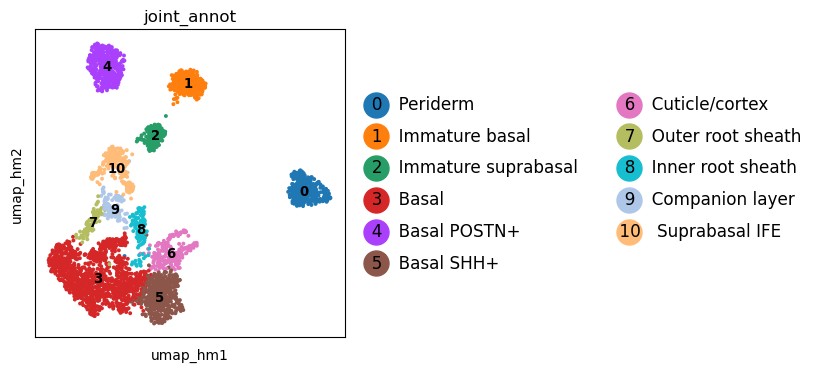

In [15]:
sk.plot_embedding(pooled_KC_ad0, basis="umap_hm", groupby="joint_annot");

In [16]:
pooled_KC_ad0.obs["joint_annot2"] = sk.regroup(
    pooled_KC_ad0,
    groupby="joint_annot",
    regroups={"Matrix/placode": "Basal SHH+", "POSTN+ basal": "Basal POSTN+"},
)

In [17]:
pooled_KC_ad0.obs.joint_annot2.cat.categories

Index(['Basal', 'Companion layer', 'Cuticle/cortex', 'Immature basal',
       'Immature suprabasal', 'Inner root sheath', 'Matrix/placode',
       'Outer root sheath', 'POSTN+ basal', 'Periderm', 'Suprabasal IFE'],
      dtype='object')

In [18]:
pooled_KC_ad0.obs.joint_annot2.cat.reorder_categories(
    [
        "Periderm",
        "Immature basal",
        "Immature suprabasal",
        "Basal",
        "POSTN+ basal",
        "Matrix/placode",
        "Cuticle/cortex",
        "Outer root sheath",
        "Inner root sheath",
        "Companion layer",
        "Suprabasal IFE",
    ],
    inplace=True,
)

In [19]:
sk.clear_colors(pooled_KC_ad0)

In [20]:
pooled_KC_ad0.uns["joint_annot2_colors"] = [
    color_codes[ct] for ct in pooled_KC_ad0.obs.joint_annot2.cat.categories
]

In [21]:
figures_path = Path(proj_root, 'figures').mkdir(parents=True, exist_ok=True)
figures_path = Path(proj_root, 'figures').resolve()

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


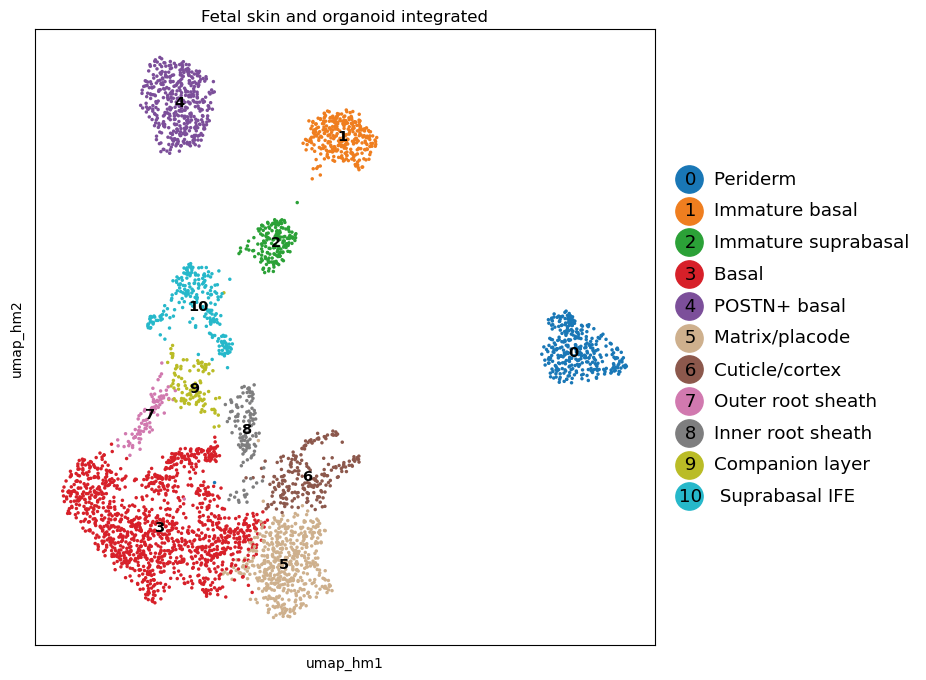

In [22]:
sk.plot_embedding(
    pooled_KC_ad0,
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    figsize=(8, 8),
    save="figures/Pooled_KC.joint_annotation.pdf",
    legend_fontsize=12,
    title="Fetal skin and organoid integrated",
);

In [23]:
pooled_KC_ad0.obs.dataset.value_counts()

organoid      2324
fetal_skin    1452
Name: dataset, dtype: int64

# Figure 2A

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


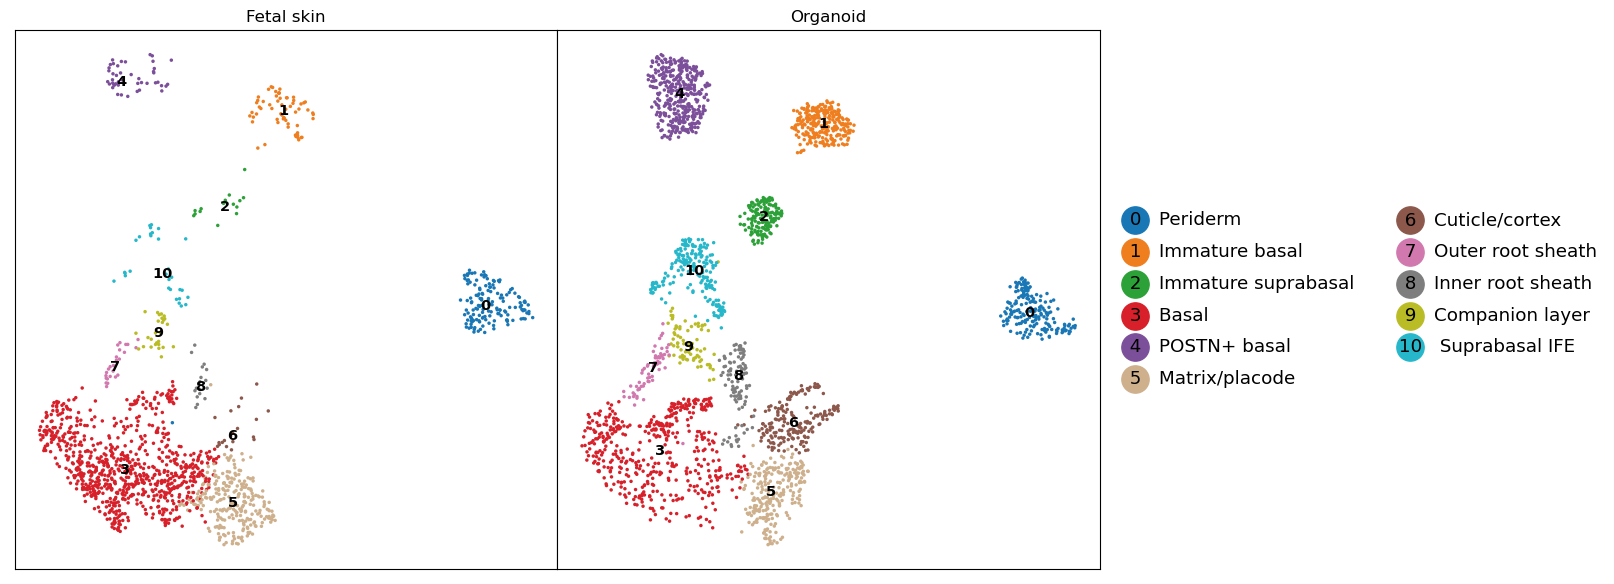

In [24]:
sk.set_figsize((14, 7))
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={"wspace": 0})

sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    legend_loc="none",
    title="Fetal skin",
    ax=axs[0],
    show=False,
)
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    title="Organoid",
    ax=axs[1],
    show=False,
)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
fig.savefig("figures/suppFig1H.pdf", bbox_inches="tight") # needs to change to supplementary figure 1H. 11/11/2022 meeting

# FigureS2C

In [ ]:
read_rie20_LR_model = str(Path(data_root, "20211124_integrate_rie20/rie20_lognorm.pkl")), # must be str

In [25]:
pred50 = sk.LR_predict(
    pooled_KC_ad0,
    rie20_lognorm_model
    use_rep="X",
    key_added="rie20_annot50",
    min_prob=0.5,
    return_predict=True,
)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
15117 features used for prediction


In [26]:
sk.LR_predict(
    pooled_KC_ad0,
    str(Path(data_root, "20211124_integrate_rie20/rie20_lognorm.pkl")), # must be str
    use_rep="X",
    key_added="rie20_annot",
    min_prob=0,
)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
15117 features used for prediction


Trying to set attribute `.uns` of view, copying.
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


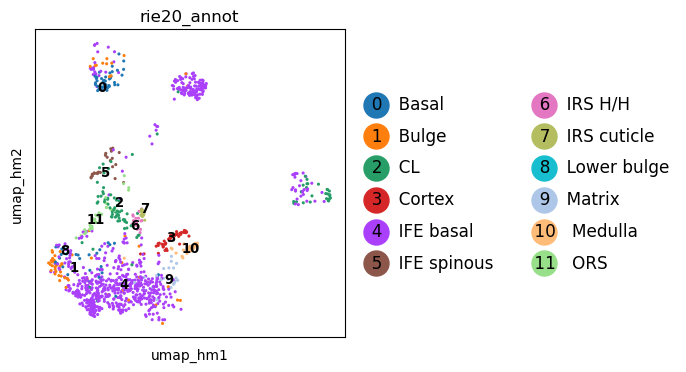

In [27]:
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.rie20_annot50 != "Uncertain"],
    basis="umap_hm",
    groupby="rie20_annot",
    size=20,
);

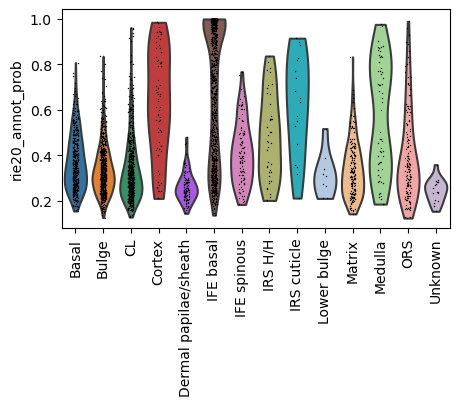

In [28]:
sk.set_figsize((5, 3))
sc.pl.violin(pooled_KC_ad0, "rie20_annot_prob", groupby="rie20_annot", rotation=90)

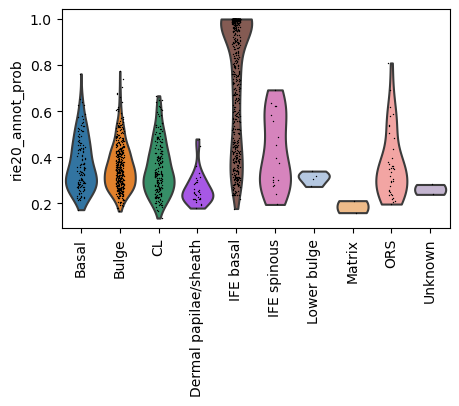

In [29]:
sk.set_figsize((5, 3))
sc.pl.violin(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    "rie20_annot_prob",
    groupby="rie20_annot",
    rotation=90,
)

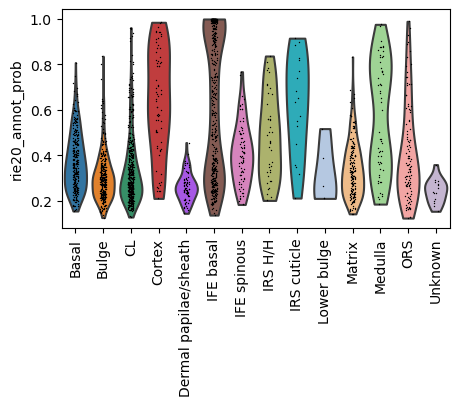

In [30]:
sk.set_figsize((5, 3))
sc.pl.violin(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    "rie20_annot_prob",
    groupby="rie20_annot",
    rotation=90,
)

In [31]:
k_fsk = pooled_KC_ad0.obs.dataset == "fetal_skin"
k_org = pooled_KC_ad0.obs.dataset == "organoid"

In [32]:
pred50_prob_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes,
        pred50["prob"].drop(columns=["Unknown"]).values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_df[pred50_prob_df.values < 0.05] = 0
pred50_prob_df = pred50_prob_df.drop(
    columns=pred50_prob_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

<span style='color:salmon; font-size:1.2em'> Missing ```joint_annot4``` column. Needs to be created as ```joint_annot2``` was above: </span>

```pooled_KC_ad0.obs["joint_annot2"] = sk.regroup( pooled_KC_ad0, groupby="joint_annot", regroups={"Matrix/placode": "Basal SHH+", "POSTN+ basal": "Basal POSTN+"},)```

In [33]:
pooled_KC_ad0.obs["joint_annot4"] = (
    pooled_KC_ad0.obs["joint_annot2"].astype(str) + ", " + pooled_KC_ad0.obs.dataset.astype(str)
)
pooled_KC_ad0.obs["joint_annot4"] = pooled_KC_ad0.obs["joint_annot4"].astype("category")

In [34]:
pred50_prob_df2 = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot4.cat.codes,
        pred50["prob"].drop(columns=["Unknown"]).values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot4.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_df2[pred50_prob_df2.values < 0.05] = 0
pred50_prob_df2 = pred50_prob_df2.drop(
    columns=pred50_prob_df2.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [35]:
pred50_prob_fsk_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes[k_fsk],
        pred50["prob"].drop(columns=["Unknown"]).loc[k_fsk].values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_fsk_df[pred50_prob_fsk_df.values < 0.05] = 0
pred50_prob_fsk_df = pred50_prob_fsk_df.drop(
    columns=pred50_prob_fsk_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [36]:
pred50_prob_org_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_KC_ad0.obs.joint_annot2.cat.codes[k_org],
        pred50["prob"].drop(columns=["Unknown"]).loc[k_org].values,
        axis=0,
        func=np.median,
    ),
    index=pooled_KC_ad0.obs.joint_annot2.cat.categories,
    columns=pred50["prob"].drop(columns=["Unknown"]).columns,
)
pred50_prob_org_df[pred50_prob_org_df.values < 0.05] = 0
pred50_prob_org_df = pred50_prob_org_df.drop(
    columns=pred50_prob_org_df.sum(axis=0).where(lambda x: x == 0).dropna().index
)

In [37]:
def norm_by_row(df):
    return df / df.sum(axis=1).values.reshape((df.shape[0], 1))


def norm_by_col(df):
    return (df.T / df.T.sum(axis=1).values.reshape((df.T.shape[0], 1))).T


def prob_df_heatmap(df, title, figsize):
    sk.set_figsize(figsize)
    fig, axs = plt.subplots(
        nrows=1, ncols=3, sharex=True, sharey=False, gridspec_kw={"wspace": 0.05}
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    dfs = [df, norm_by_row(df), norm_by_col(df)]
    for i, ax in enumerate(axs):
        sn.heatmap(
            dfs[i],
            ax=ax,
            cbar=(i == 0),
            vmin=0,
            vmax=1,
            yticklabels=(i == 0),
            cbar_ax=None if i else cbar_ax,
            cmap="viridis_r",
            linewidth=0.01,
        )
        plt.close() # To avoid outputting the subplot twice.

    fig.suptitle(title)
    return fig


def frac_df_heatmap(ad, var1, var2, title, figsize):
    sk.set_figsize(figsize)
    fig, axs = plt.subplots(
        nrows=1, ncols=3, sharex=True, sharey=False, gridspec_kw={"wspace": 0.05}
    )
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
#     dfs = [
#         sk.cross_table(ad, var1, var2, normalise="x") / 100,
#         sk.cross_table(ad, var1, var2, normalise="y") / 100,
#         sk.cross_table(ad, var1, var2, normalise="xy") / 100,
#     ]
    
    dfs = [
        sk.cross_table(ad, var1, var2, normalise="x"),
        sk.cross_table(ad, var1, var2, normalise="y"),
        sk.cross_table(ad, var1, var2, normalise="xy"),
    ]

    for i, ax in enumerate(axs):
        sn.heatmap(
            dfs[i],
            ax=ax,
            cbar=(i == 0),
            vmin=0,
            vmax=1,
            yticklabels=(i == 0),
            cbar_ax=None if i else cbar_ax,
            cmap="viridis_r",
            linewidth=0.01,
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.close() # To avoid outputting the subplot twice.

    fig.suptitle(title)
    return fig

Text(0.5, 0.98, 'median probability of cell type prediction')

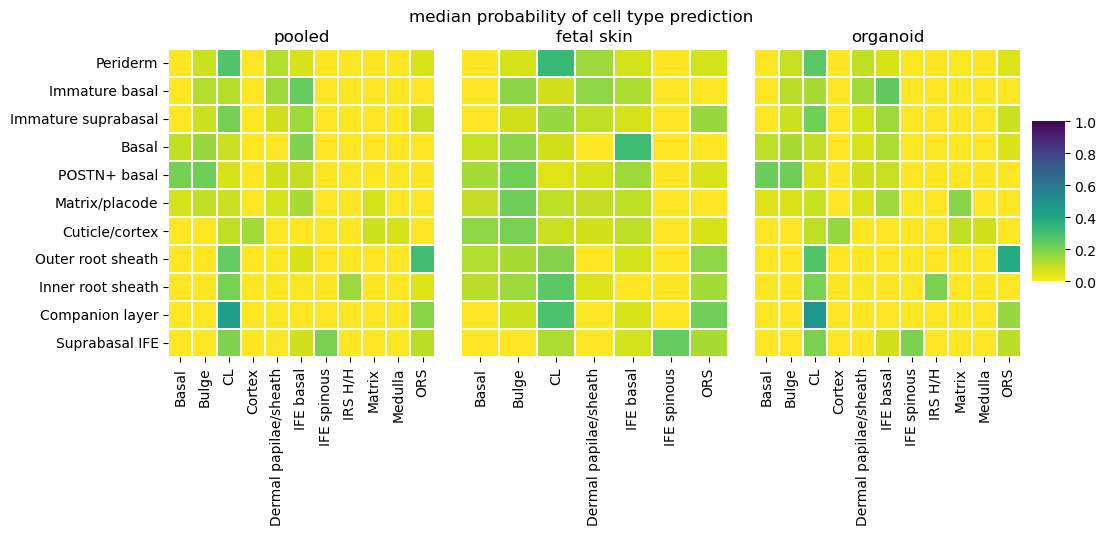

In [38]:
sk.set_figsize((11, 4))
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, gridspec_kw={"wspace": 0.1})
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
dfs = [pred50_prob_df, pred50_prob_fsk_df, pred50_prob_org_df]
sub_titles = ["pooled", "fetal skin", "organoid"]
for i, ax in enumerate(axs):
    sn.heatmap(
        dfs[i],
        ax=ax,
        cbar=(i == 0),
        vmin=0,
        vmax=1,
        yticklabels=(i == 0),
        cbar_ax=None if i else cbar_ax,
        cmap="viridis_r",
        linewidth=0.01,
    )
    ax.set_title(sub_titles[i])
fig.suptitle("median probability of cell type prediction")

In [39]:
pred50_prob_df.head()

Basal     Bulge        CL  Cortex  \
Periderm             0.000000  0.080212  0.275827     0.0   
Immature basal       0.000000  0.115775  0.113247     0.0   
Immature suprabasal  0.000000  0.078594  0.207930     0.0   
Basal                0.093086  0.154639  0.082416     0.0   
POSTN+ basal         0.210231  0.219518  0.064281     0.0   

                     Dermal papilae/sheath  IFE basal  IFE spinous  IRS H/H  \
Periderm                          0.116783   0.063716          0.0      0.0   
Immature basal                    0.145895   0.234438          0.0      0.0   
Immature suprabasal               0.071512   0.145452          0.0      0.0   
Basal                             0.000000   0.193366          0.0      0.0   
POSTN+ basal                      0.072541   0.090050          0.0      0.0   

                     Matrix  Medulla       ORS  
Periderm                0.0      0.0  0.056967  
Immature basal          0.0      0.0  0.000000  
Immature suprabasal     0.0      0.0  0.082629  
Basal                   0.0      0.0  0.000000  
POSTN+ basal            0.0      0.0  0.000000

In [40]:
fig = prob_df_heatmap(pred50_prob_df.drop(index=["Periderm"]), "pooled", figsize=(11, 4))
fig.savefig("figures/figS2C_pooled_prob.pdf", bbox_inches="tight")

In [41]:
# !rclone copy --drive-shared-with-me figures/figS2C_pooled_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [42]:
fig = frac_df_heatmap(
    pooled_KC_ad0[pooled_KC_ad0.obs.joint_annot2 != "Periderm"],
    "joint_annot2",
    "rie20_annot50",
    "pooled",
    figsize=(11, 4),
)
fig.savefig("figures/figS2C_pooled_frac.pdf", bbox_inches="tight")

In [43]:
# !rclone copy --drive-shared-with-me figures/figS2C_pooled_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [44]:
fig = prob_df_heatmap(pred50_prob_fsk_df.drop(index=["Periderm"]), "fetal skin", figsize=(8, 4))
fig.savefig("figures/figS2C_fsk_prob.pdf", bbox_inches="tight")

In [45]:
# !rclone copy --drive-shared-with-me figures/figS2C_fsk_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [46]:
fig = frac_df_heatmap(
    pooled_KC_ad0[k_fsk & (pooled_KC_ad0.obs.joint_annot2 != "Periderm")],
    "joint_annot2",
    "rie20_annot50",
    "fetal skin",
    figsize=(8, 4),
)
fig.savefig("figures/figS2C_fsk_frac.pdf", bbox_inches="tight")

In [47]:
# !rclone copy --drive-shared-with-me figures/figS2C_fsk_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [48]:
fig = prob_df_heatmap(pred50_prob_org_df.drop(index=["Periderm"]), "organoid", figsize=(11, 4))
fig.savefig("figures/figS2C_org_prob.pdf", bbox_inches="tight")

In [49]:
# !rclone copy --drive-shared-with-me figures/figS2C_org_prob.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [50]:
fig = frac_df_heatmap(
    pooled_KC_ad0[k_org & (pooled_KC_ad0.obs.joint_annot2 != "Periderm")],
    "joint_annot2",
    "rie20_annot50",
    "organoid",
    figsize=(11, 4),
)
fig.savefig("figures/figS2C_org_frac.pdf", bbox_inches="tight")

In [51]:
# !rclone copy --drive-shared-with-me figures/figS2C_org_frac.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

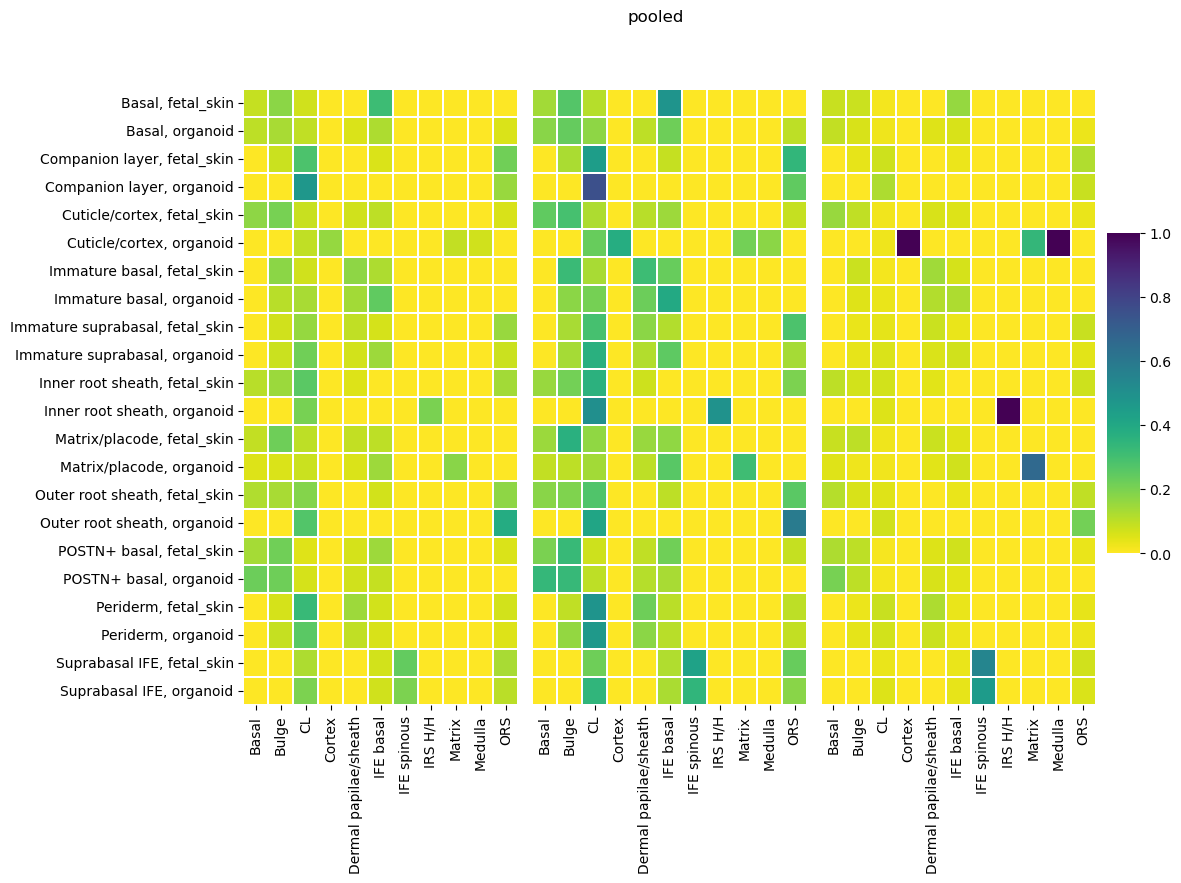

In [52]:
prob_df_heatmap(pred50_prob_df2, "pooled", figsize=(11, 8))

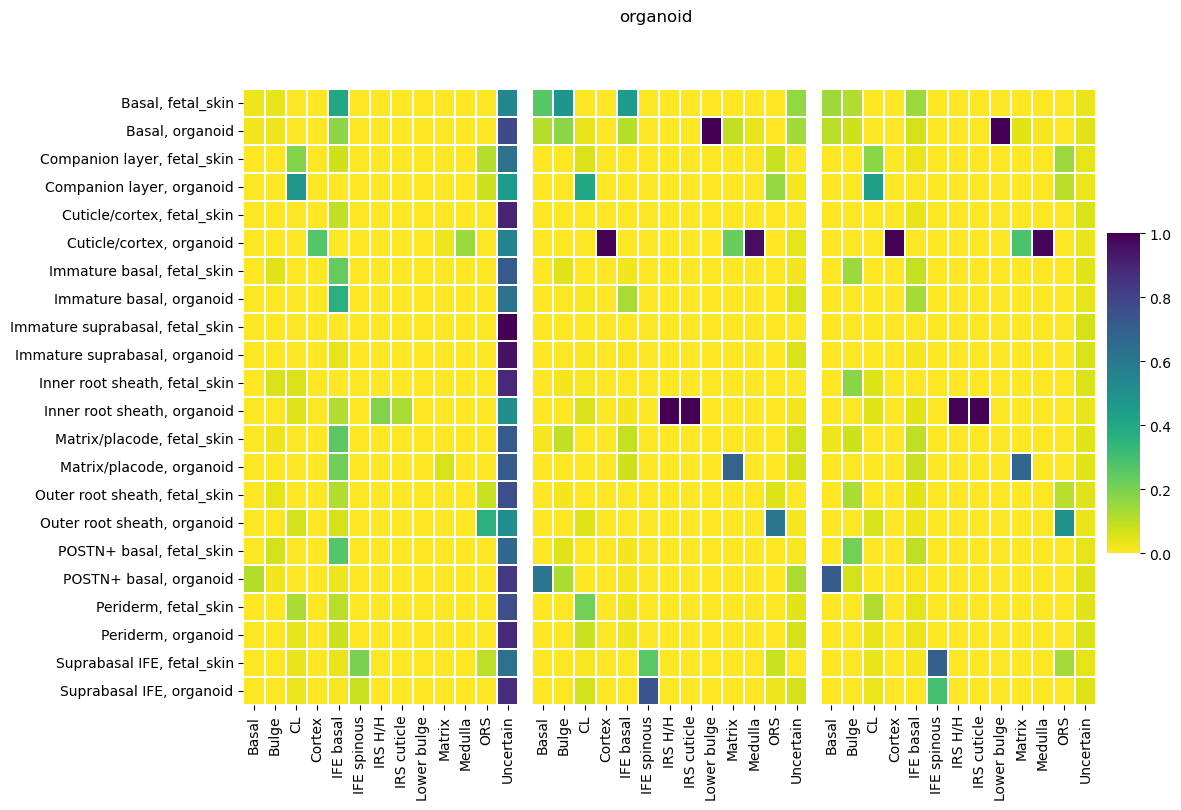

In [53]:
frac_df_heatmap(pooled_KC_ad0, "joint_annot4", "rie20_annot50", "organoid", figsize=(11, 8))

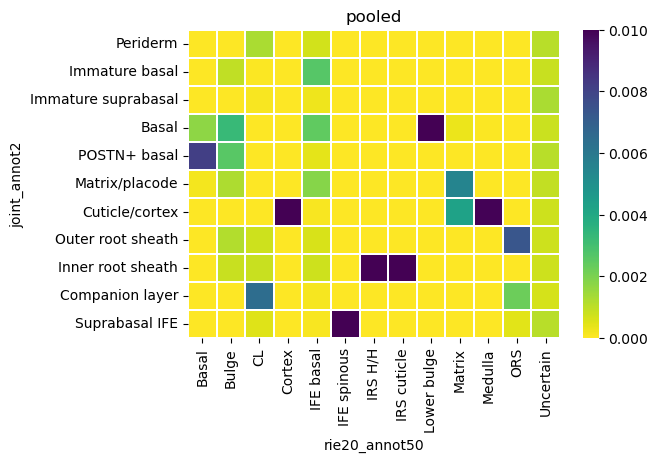

In [54]:
sk.set_figsize((6, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0, "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("pooled");

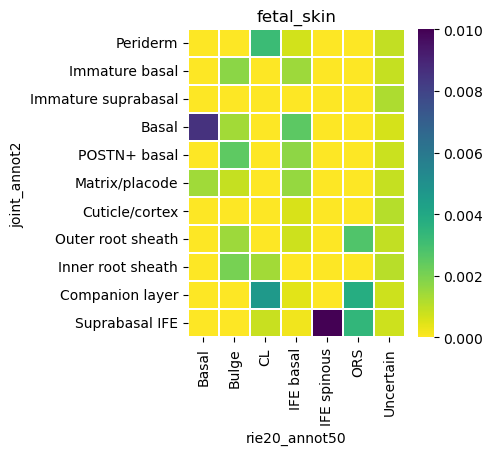

In [55]:
sk.set_figsize((3.5, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0[k_fsk], "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("fetal_skin");

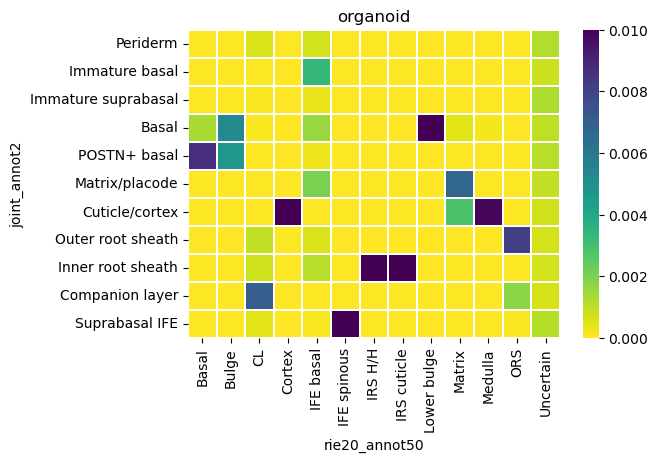

In [56]:
sk.set_figsize((6, 4))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0[k_org], "joint_annot2", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("organoid");

In [57]:
pooled_KC_ad0.obs["joint_annot3"] = (
    pooled_KC_ad0.obs.dataset.astype(str) + ", " + pooled_KC_ad0.obs["joint_annot2"].astype(str)
)
pooled_KC_ad0.obs["joint_annot3"] = pooled_KC_ad0.obs["joint_annot3"].astype("category")

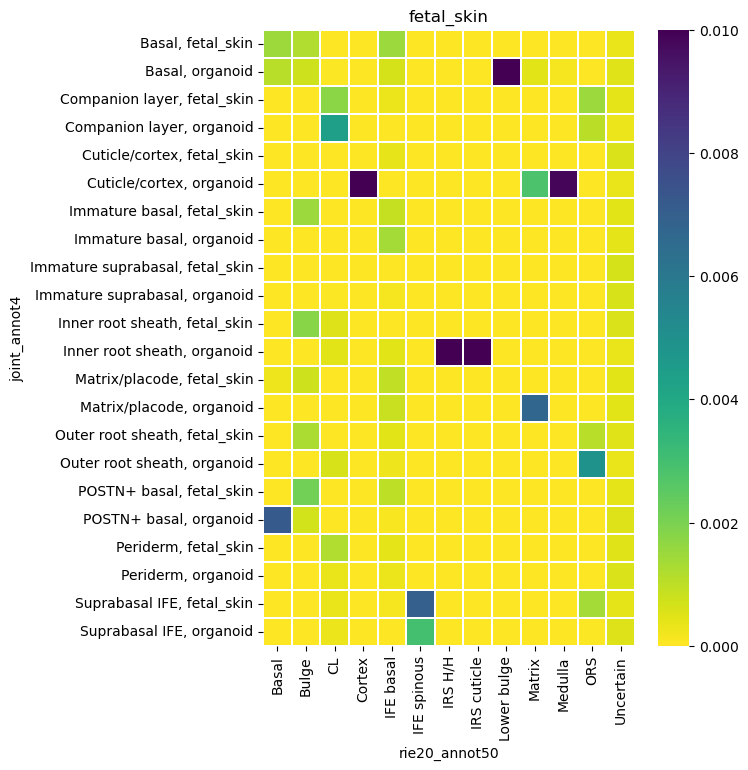

In [58]:
sk.set_figsize((6, 8))
ax = sn.heatmap(
    sk.cross_table(pooled_KC_ad0, "joint_annot4", "rie20_annot50", normalise="xy") / 100,
    cmap="viridis_r",
    linewidth=0.01,
)
ax.set_title("fetal_skin");

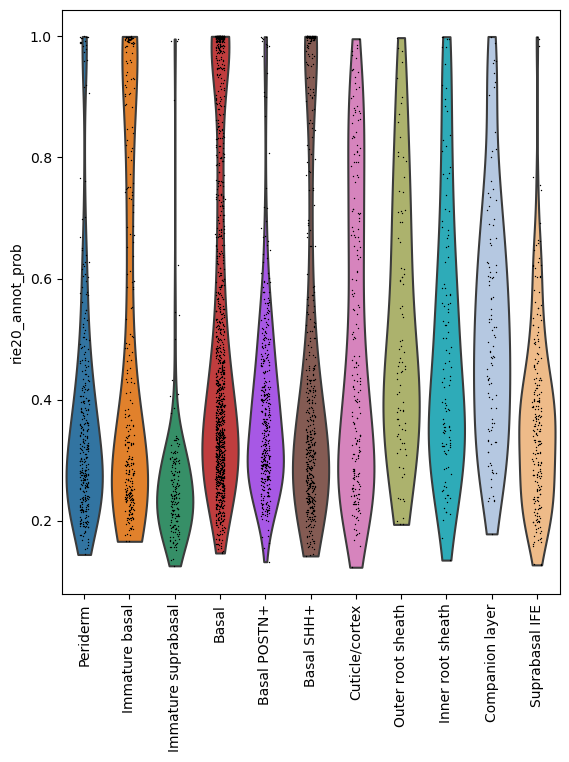

In [59]:
sc.pl.violin(pooled_KC_ad0, "rie20_annot_prob", groupby="joint_annot", rotation=90)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


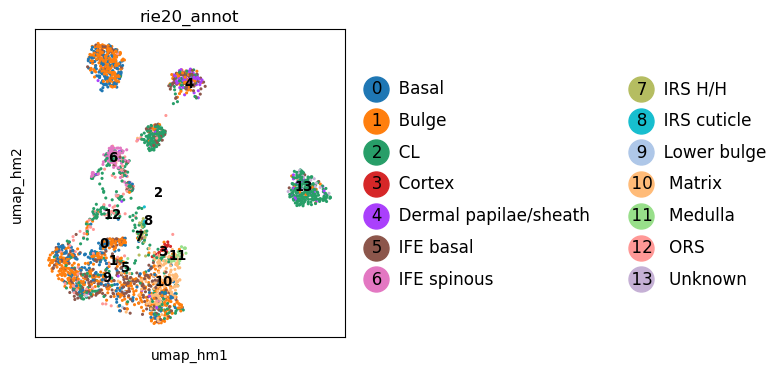

In [60]:
sk.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.rie20_annot50 == "Uncertain"],
    basis="umap_hm",
    groupby="rie20_annot",
    size=20,
);

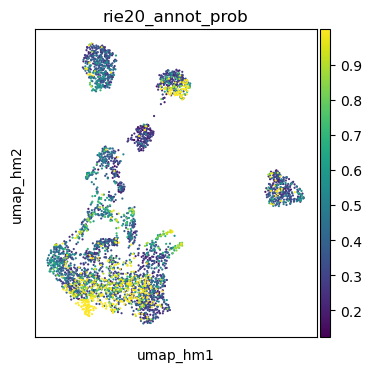

In [61]:
sc.pl.embedding(pooled_KC_ad0, basis="umap_hm", color="rie20_annot_prob", size=10);

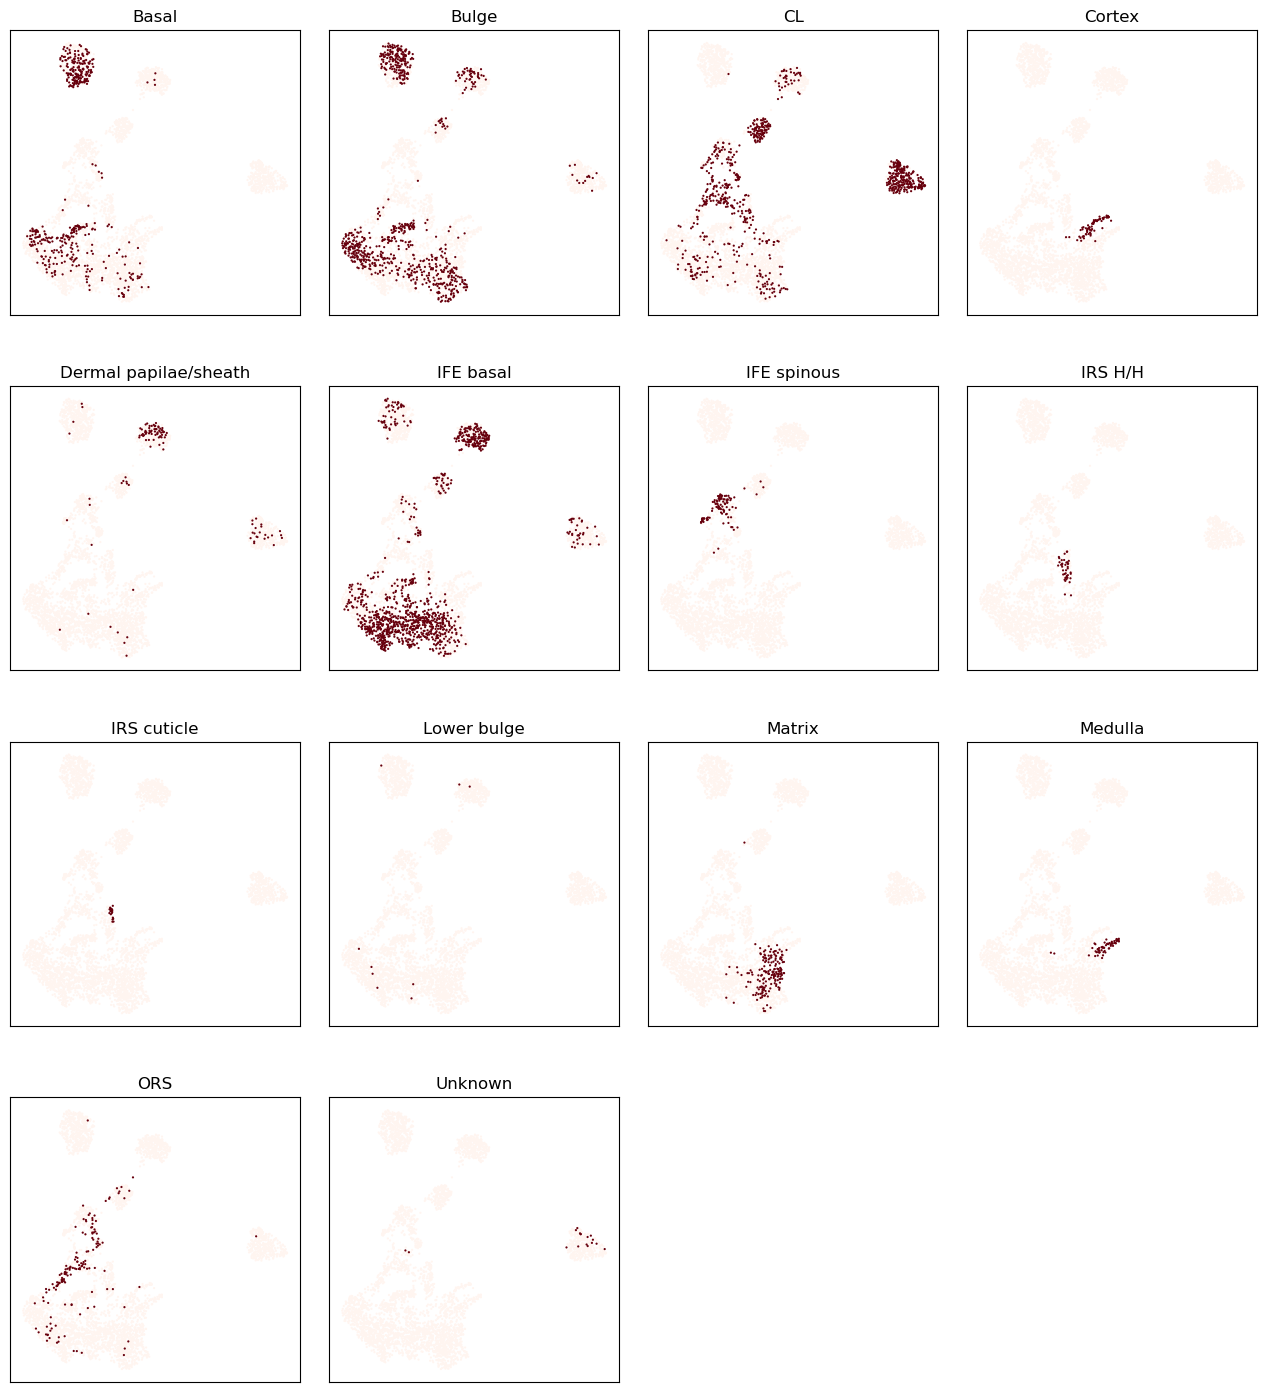

In [62]:
sk.highlight(pooled_KC_ad0, basis="umap_hm", groupby="rie20_annot", size=10, wspace=0);

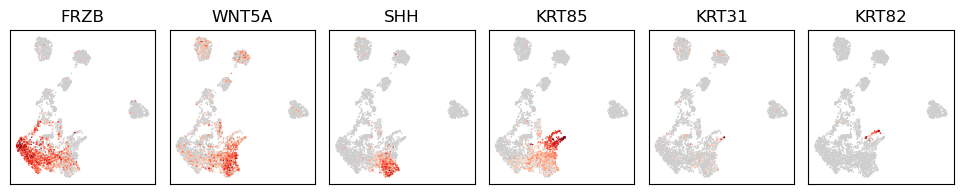

In [63]:
sk.plot_genes(
    pooled_KC_ad0,
    basis="umap_hm",
    genes=["FRZB", "WNT5A", "SHH", "KRT85", "KRT31", "KRT82"],
    figsize=(2, 2),
    size=5,
)

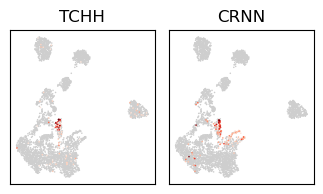

In [64]:
sk.plot_genes(
    pooled_KC_ad0, basis="umap_hm", genes=["TCHH", "KRT71", "KRT73", "CRNN"], figsize=(2, 2), size=5
)

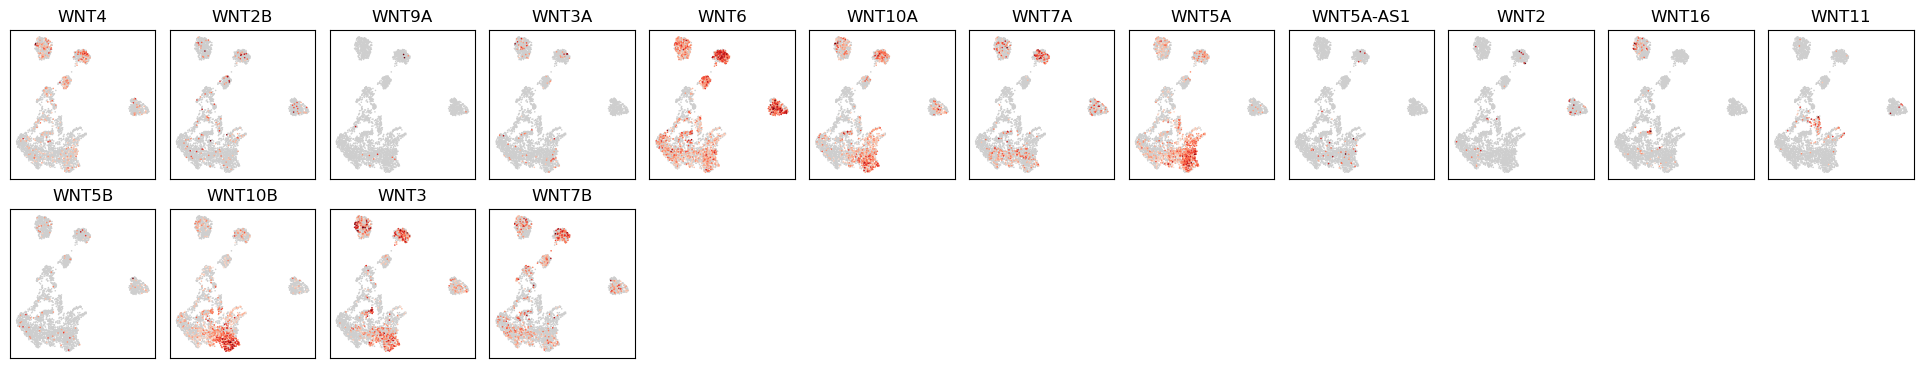

In [65]:
sk.plot_genes(
    pooled_KC_ad0,
    basis="umap_hm",
    genes=pooled_KC_ad0.var_names[pd.Series(pooled_KC_ad0.var_names).str.startswith("WNT")],
    figsize=(2, 2),
    size=5,
)

# DEG in KC

In [66]:
fsk_mkst = sk.calc_marker_stats(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"], use_rep="X", groupby="joint_annot2"
)

In [67]:
fsk_mks = sk.filter_marker_stats(
    fsk_mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.3, single=True, how="and"
)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


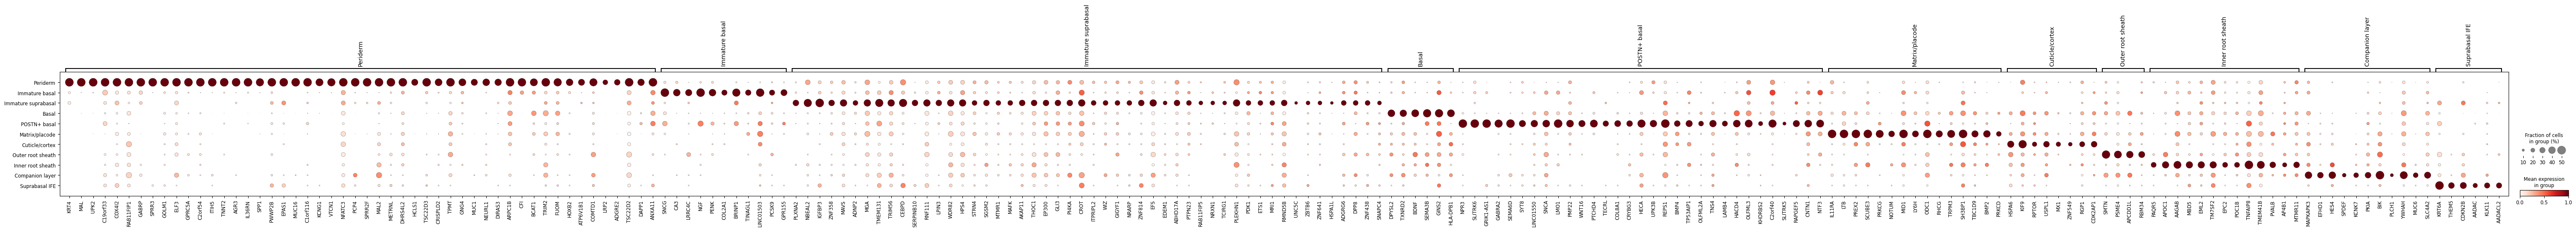

In [68]:
sk.plot_markers(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    groupby="joint_annot2",
    mks=fsk_mks,
    n_genes=50,
    standard_scale="var",
    dot_max=0.5,
)

In [69]:
org_mkst = sk.calc_marker_stats(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"], use_rep="X", groupby="joint_annot2"
)

In [70]:
org_mks = sk.filter_marker_stats(
    org_mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.4, single=False, how="and"
)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


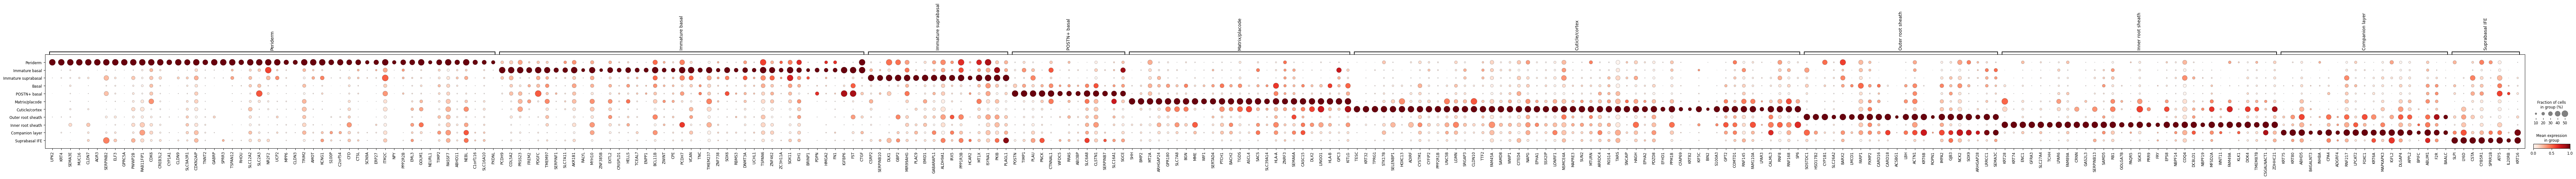

In [71]:
sk.plot_markers(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    groupby="joint_annot2",
    mks=org_mks,
    n_genes=50,
    standard_scale="var",
    dot_max=0.5,
)

In [72]:
fsk_mks.groupby("top_frac_group").head(4)

top_frac_group  top_frac  frac_diff  max_frac_diff  \
KRT4                  Periderm  0.979866   0.846532       0.886116   
MAL                   Periderm  0.879195   0.863570       0.874226   
UPK2                  Periderm  0.812081   0.780831       0.807112   
C19orf33              Periderm  0.879195   0.613570       0.679195   
SNCG            Immature basal  0.640625   0.396181       0.500252   
CA3             Immature basal  0.406250   0.305579       0.358631   
LRRC4C          Immature basal  0.375000   0.175000       0.308333   
NGF             Immature basal  0.531250   0.242361       0.464136   
PLXNA2     Immature suprabasal  0.333333   0.270833       0.277778   
NBEAL2     Immature suprabasal  0.466667   0.211633       0.355556   
IGFBP3     Immature suprabasal  0.600000   0.433333       0.452349   
ZNF358     Immature suprabasal  0.333333   0.194993       0.219239   
DPYSL2                   Basal  0.416149   0.256149       0.268001   
TXNRD2                   Basal  0.396273   0.211088       0.250028   
BDNF                     Basal  0.437267   0.197267       0.302880   
SEMA3B                   Basal  0.478261   0.278261       0.278261   
NPR3              POSTN+ basal  0.777778   0.697778       0.705728   
SLITRK6           POSTN+ basal  0.577778   0.463684       0.468403   
GRIK1-AS1         POSTN+ basal  0.577778   0.477778       0.484028   
GABRA2            POSTN+ basal  0.466667   0.392593       0.400000   
IL11RA          Matrix/placode  0.557312   0.382816       0.446201   
LTB             Matrix/placode  0.584980   0.383738       0.407202   
PREX2           Matrix/placode  0.529644   0.339168       0.362978   
SCUBE3          Matrix/placode  0.616601   0.394379       0.426125   
HSPA6           Cuticle/cortex  0.380952   0.140952       0.214286   
KIF9            Cuticle/cortex  0.476190   0.204141       0.246941   
RPTOR           Cuticle/cortex  0.238095   0.103708       0.106418   
USPL1           Cuticle/cortex  0.333333   0.148148       0.149482   
SMTN         Outer root sheath  0.480000   0.257778       0.311056   
PSME4        Outer root sheath  0.440000   0.217778       0.241242   
APCDD1L      Outer root sheath  0.400000   0.172671       0.177778   
RBM34        Outer root sheath  0.360000   0.217708       0.265590   
PAQR5        Inner root sheath  0.277778   0.197778       0.217375   
APOC1        Inner root sheath  0.388889   0.148889       0.279514   
AAGAB        Inner root sheath  0.444444   0.175670       0.184817   
MBD5         Inner root sheath  0.388889   0.222881       0.244790   
MAPKAPK3       Companion layer  0.407407   0.204923       0.216931   
EFHD1          Companion layer  0.333333   0.277778       0.281950   
HES4           Companion layer  0.407407   0.185185       0.307407   
SPDEF          Companion layer  0.185185   0.185185       0.185185   
KRT6A           Suprabasal IFE  0.633333   0.393333       0.411111   
THEM5           Suprabasal IFE  0.333333   0.293333       0.296296   
CDKN2B          Suprabasal IFE  0.366667   0.144444       0.166667   
AADAC           Suprabasal IFE  0.233333   0.188889       0.230849   

                top_mean_group  top_mean  mean_diff  max_mean_diff  
KRT4                  Periderm  0.688789   0.651123       0.667752  
MAL                   Periderm  0.593279   0.585137       0.592148  
UPK2                  Periderm  0.433711   0.421019       0.432514  
C19orf33              Periderm  0.505679   0.403676       0.425295  
SNCG            Immature basal  0.337230   0.242330       0.299743  
CA3             Immature basal  0.225243   0.192067       0.196117  
LRRC4C          Immature basal  0.246470   0.178189       0.193889  
NGF             Immature basal  0.290730   0.163818       0.266093  
PLXNA2     Immature suprabasal  0.278886   0.251027       0.255317  
NBEAL2     Immature suprabasal  0.356744   0.245147       0.306031  
IGFBP3     Immature suprabasal  0.300109   0.215939       0.245645  
ZNF358     Immature suprabasal  0.259

In [73]:
org_mks.groupby("top_frac_group").head(4)

top_frac_group  top_frac  frac_diff  max_frac_diff  \
UPK2                  Periderm  0.648936   0.633063       0.636358   
KRT4                  Periderm  0.680851   0.628903       0.630537   
SEMA3E                Periderm  0.707447   0.489625       0.611087   
MUC16                 Periderm  0.617021   0.528971       0.614403   
PCDH9           Immature basal  0.728346   0.533378       0.536857   
COL5A2          Immature basal  0.681102   0.379216       0.421940   
PRSS23          Immature basal  0.692913   0.317913       0.368445   
FREM2           Immature basal  0.440945   0.200281       0.269639   
CSRP2      Immature suprabasal  0.635220   0.365511       0.442307   
SERPINB10  Immature suprabasal  0.446541   0.311541       0.331358   
DLK1       Immature suprabasal  0.842767   0.374682       0.502767   
GBP2       Immature suprabasal  0.647799   0.243543       0.314465   
POSTN             POSTN+ basal  0.863874   0.600491       0.743874   
TIMP1             POSTN+ basal  0.594241   0.302902       0.356553   
PLAU              POSTN+ basal  0.578534   0.213754       0.263534   
PNCK              POSTN+ basal  0.573298   0.213298       0.390726   
SHH             Matrix/placode  0.514523   0.415513       0.465272   
BMP2            Matrix/placode  0.634855   0.494230       0.506583   
MT2A            Matrix/placode  0.738589   0.387525       0.447369   
ARHGAP24        Matrix/placode  0.593361   0.296331       0.354367   
TESC            Cuticle/cortex  0.598958   0.572984       0.583085   
KRT32           Cuticle/cortex  0.802083   0.703073       0.739843   
TPRG1           Cuticle/cortex  0.593750   0.542569       0.543750   
STK17B          Cuticle/cortex  0.734375   0.461648       0.516290   
SOSTDC1      Outer root sheath  0.809524   0.354978       0.459130   
HSD17B2      Outer root sheath  0.476190   0.229437       0.396190   
CYP1B1       Outer root sheath  0.619048   0.252026       0.496992   
SLC26A2      Outer root sheath  0.301587   0.210678       0.213537   
KRT28        Inner root sheath  0.940594   0.272544       0.586427   
KRT74        Inner root sheath  0.633663   0.555741       0.591997   
ENC1         Inner root sheath  0.663366   0.471877       0.494535   
GFRA3        Inner root sheath  0.504950   0.465989       0.484117   
KRT75          Companion layer  0.428571   0.285714       0.319661   
KRT80          Companion layer  0.519481   0.217893       0.339481   
ABHD5          Companion layer  0.662338   0.217893       0.315803   
B4GALNT3       Companion layer  0.272727   0.184186       0.193519   
SLPI            Suprabasal IFE  0.520000   0.273247       0.285957   
LY6D            Suprabasal IFE  0.635000   0.180455       0.285794   
CSTA            Suprabasal IFE  0.595000   0.211352       0.322749   
CYB5R1          Suprabasal IFE  0.500000   0.164894       0.214286   

                top_mean_group  top_mean  mean_diff  max_mean_diff  
UPK2                  Periderm  0.395738   0.392878       0.393175  
KRT4                  Periderm  0.383092   0.369703       0.372388  
SEMA3E                Periderm  0.364060   0.311608       0.335338  
MUC16                 Periderm  0.329202   0.302800       0.328755  
PCDH9           Immature basal  0.300523   0.236862       0.241442  
COL5A2          Immature basal  0.329506   0.232964       0.243718  
PRSS23          Immature basal  0.321170   0.216272       0.220543  
FREM2           Immature basal  0.240961   0.158400       0.171015  
CSRP2      Immature suprabasal  0.299559   0.213911       0.215147  
SERPINB10  Immature suprabasal  0.245385   0.188183       0.188691  
DLK1       Immature suprabasal  0.330336   0.171708       0.247656  
GBP2       Immature suprabasal  0.305018   0.159146       0.179197  
POSTN             POSTN+ basal  0.512900   0.413697       0.486810  
TIMP1             POSTN+ basal  0.256855   0.152550       0.165680  
PLAU              POSTN+ basal  0.252945   0.135397       0.155706  
PNCK              POSTN+ basal  0.280298 

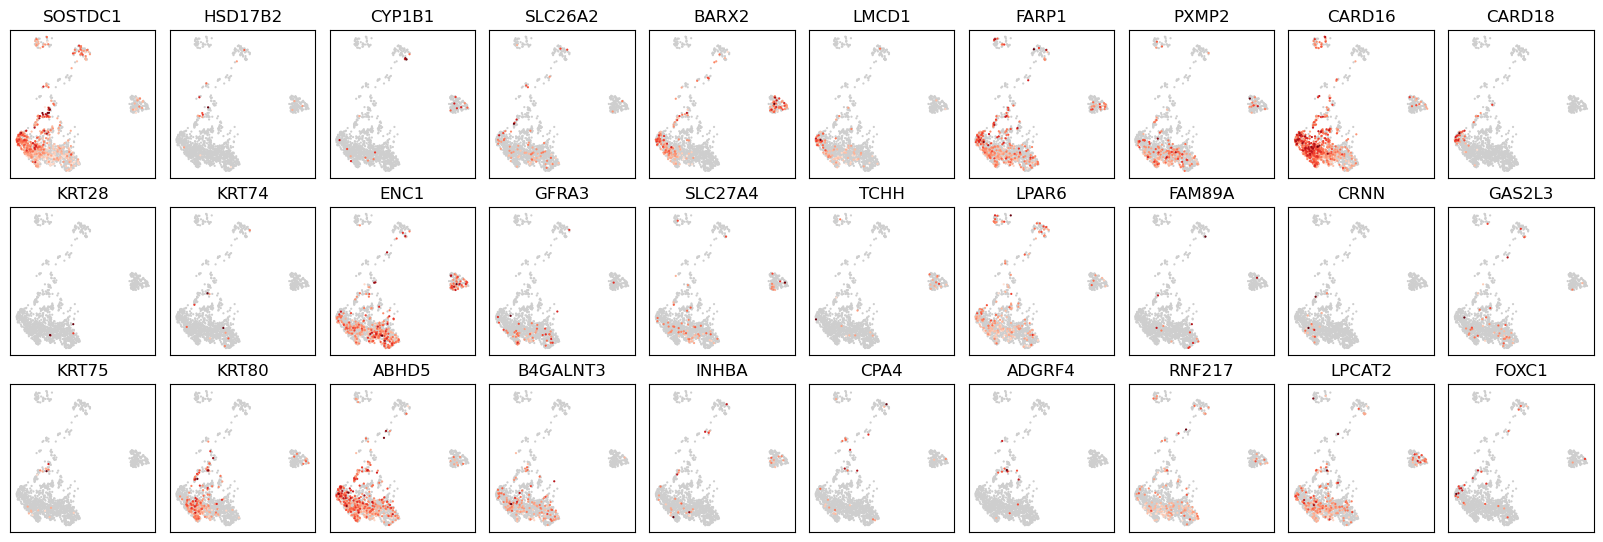

In [74]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    org_mks[
        org_mks.top_frac_group.isin(["Outer root sheath", "Inner root sheath", "Companion layer"])
    ]
    .groupby("top_frac_group")
    .head(10)
    .index,
    basis="umap_hm",
    size=10,
    ncols=10,
)

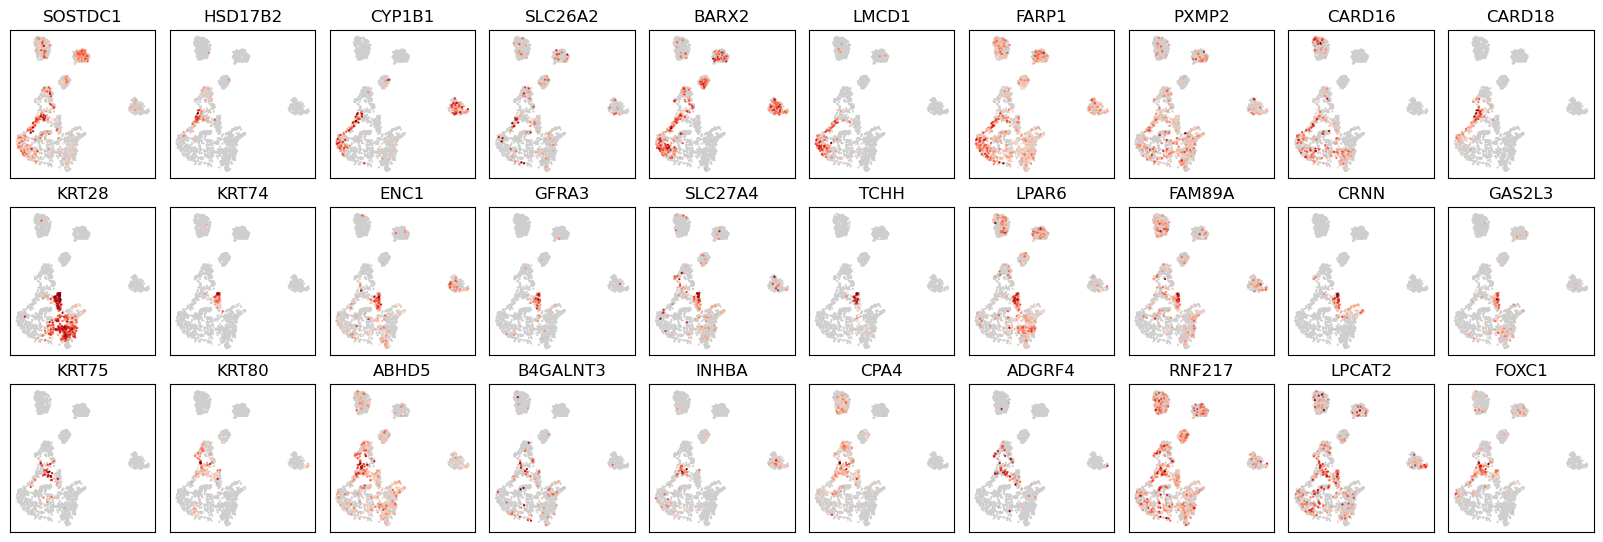

In [75]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    org_mks[
        org_mks.top_frac_group.isin(["Outer root sheath", "Inner root sheath", "Companion layer"])
    ]
    .groupby("top_frac_group")
    .head(10)
    .index,
    basis="umap_hm",
    size=10,
    ncols=10,
)

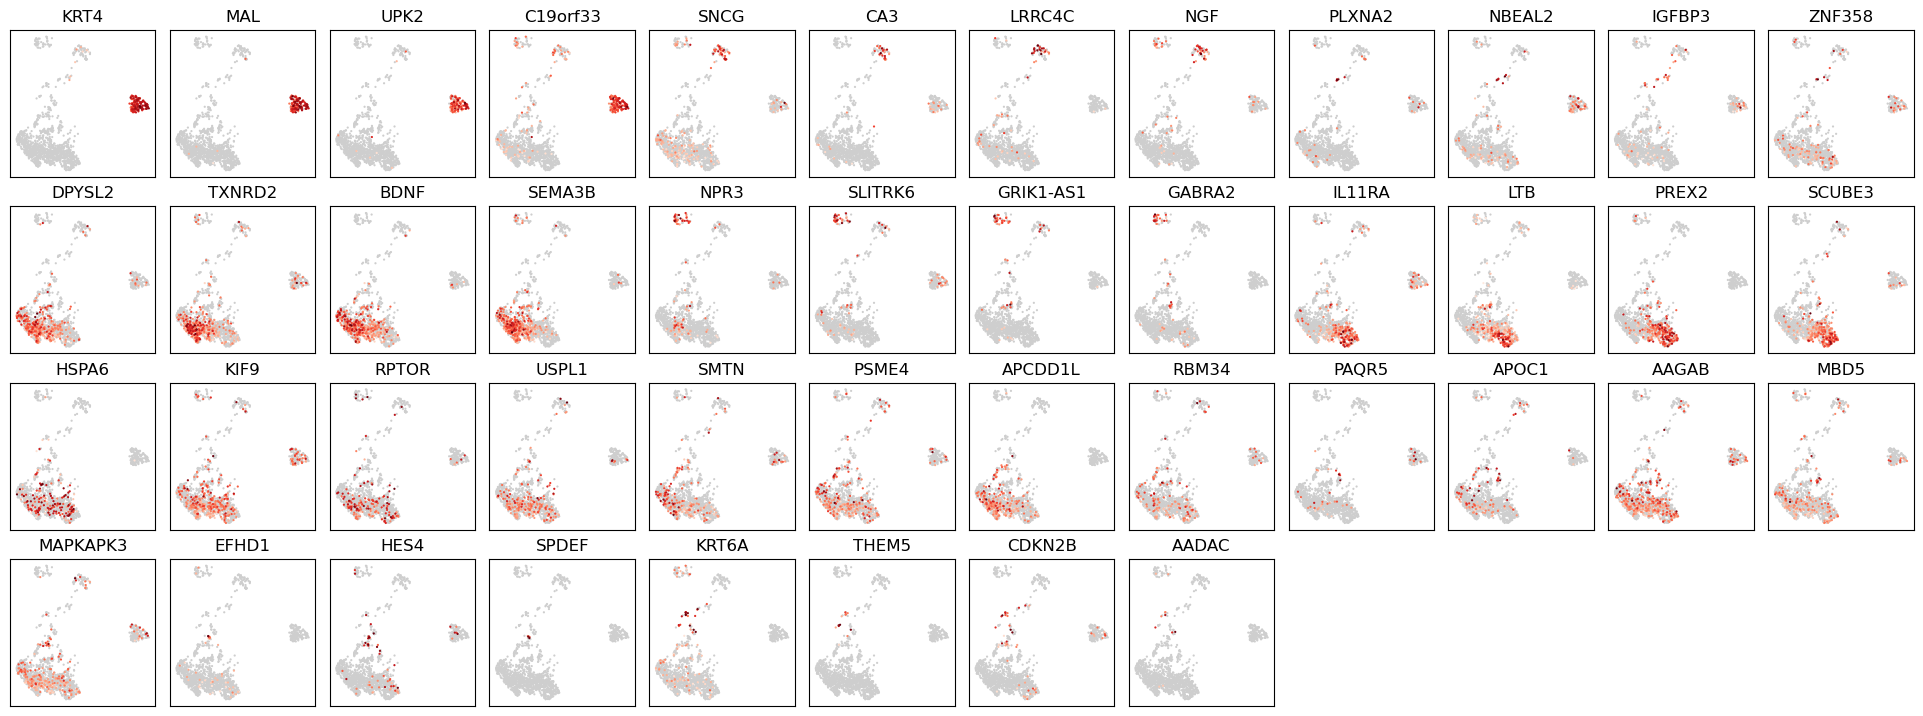

In [76]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    fsk_mks.groupby("top_frac_group").head(4).index,
    basis="umap_hm",
    size=10,
)

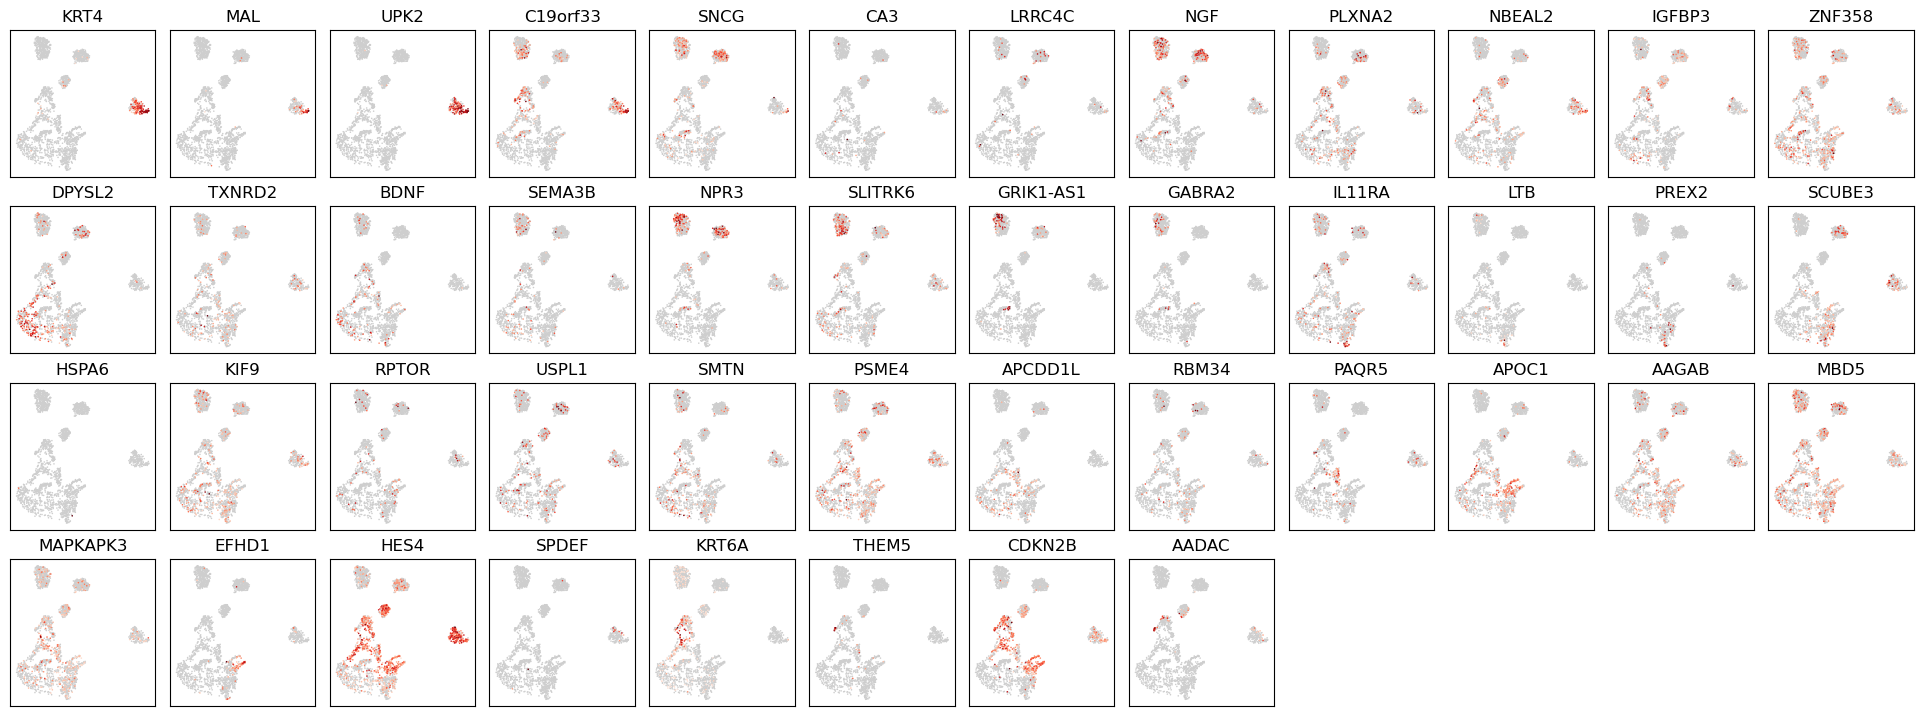

In [77]:
sk.plot_genes(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "organoid"],
    fsk_mks.groupby("top_frac_group").head(4).index,
    basis="umap_hm",
    size=5,
)

<span style="color:red; size:1.9em"> Obsolete from here on out </span>

In [78]:
sk._neighbors.neighbors(pooled_KC_ad0, use_rep="X_umap_hm", key_added="diffmap_hm")

In [79]:
sk.umap(pooled_KC_ad0, use_graph="neighbors_diffmap_hm", key_added="diffmap_hm")

In [80]:
sk.fdg(pooled_KC_ad0, use_graph="neighbors_diffmap_hm", key_added="diffmap_hm")

In [81]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15277
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'annot', 'joint_annot', 'joint_annot2', 'rie20_annot50', 'rie20_annot50_prob', 'rie20_annot', 'rie20_annot_prob', 'joint_annot4', 'joint_annot3'
    var: 'gene_ids'
    uns: 'neighbors_diffmap_hm', 'umap', 'draw_graph'
    obsm: 'X_umap_hm', 'X_umap_diffmap_hm', 'X_draw_graph_fa_diffmap_hm'
    obsp: 'neighbors_diffmap_hm_distances', 'neighbors_diffmap_hm_connectivities'

In [85]:
sk.paga(pooled_KC_ad0, groups="joint_annot", use_graph="neighbors_hm", key_added="hm")

KeyError: 'neighbors_hm does not exist'

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


KeyError: 'paga_hm'

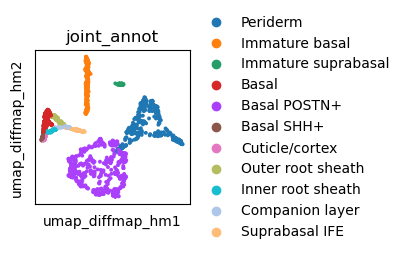

In [86]:
sk.plot_paga(
    pooled_KC_ad0,
    use_key="paga_hm",
    solid_edges="connectivities",
    basis="umap_diffmap_hm",
    color="joint_annot",
    legend_loc="right margin",
)

In [87]:
sk.diffmap(pooled_KC_ad0, use_graph="neighbors_hm", key_added="hm")

KeyError: 'neighbors_hm does not exist'

In [83]:
pooled_KC_ad0.obsm["X_draw_graph_fa_diffmap_hm"].shape

(3776, 2)

In [119]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15277
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'annot', 'joint_annot', 'joint_annot2', 'rie20_annot50', 'rie20_annot50_prob', 'rie20_annot', 'rie20_annot_prob', 'joint_annot4', 'joint_annot3'
    var: 'gene_ids'
    uns: 'neighbors_diffmap_hm', 'neighbors', 'paga', 'umap', 'paga_bkup', 'draw_graph', 'joint_annot_colors'
    obsm: 'X_umap_hm', 'X_umap_diffmap_hm', 'X_draw_graph_fr'
    obsp: 'neighbors_diffmap_hm_distances', 'neighbors_diffmap_hm_connectivities'

Trying to set attribute `.uns` of view, copying.
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


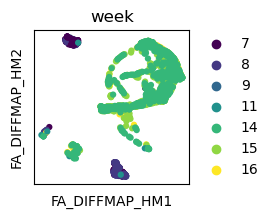

In [88]:
sc.pl.embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="draw_graph_fa_diffmap_hm",
    color="week",
    palette="viridis",
);

In [97]:
pooled_KC_ad0

AnnData object with n_obs × n_vars = 3776 × 15277
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'sample_id', 'strain', 'week', 'annot', 'joint_annot', 'joint_annot2', 'rie20_annot50', 'rie20_annot50_prob', 'rie20_annot', 'rie20_annot_prob', 'joint_annot4', 'joint_annot3'
    var: 'gene_ids'
    uns: 'neighbors_diffmap_hm', 'umap', 'draw_graph', 'joint_annot_colors'
    obsm: 'X_umap_hm', 'X_umap_diffmap_hm', 'X_draw_graph_fa_diffmap_hm'
    obsp: 'neighbors_diffmap_hm_distances', 'neighbors_diffmap_hm_connectivities'

In [96]:
sk._plot.plot_embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == ],
    basis="draw_graph_fa_diffmap_hm",
    color="joint_annot",
);

KeyError: '"fetal_skin" not found in `adata.obs`.'

In [ ]:
sk.pl.embedding(
    pooled_KC_ad0[pooled_KC_ad0.obs.dataset == "fetal_skin"],
    basis="umap_diffmap_hm",
    color="joint_annot",
);

In [ ]:
sk.cross_table(pooled_KC_ad0, "donor", "joint_annot")

In [ ]:
sk.highlight(pooled_KC_ad0, basis="umap_hm", groupby="week", figsize=(2, 2), wspace=0, ncols=6);

In [ ]:
pooled_KC_ad0.obs["stage"] = sk.regroup(
    pooled_KC_ad0,
    groupby="week",
    regroups={
        "4-7 week": ["4-7_fetal_wks", "7"],
        "8-12 week": ["7-10_fetal_wks", "8", "9", "11"],
        "13-16 week": ["14", "14-16_fetal_wks", "15", "16"],
        "17-20 week": ["17-20_fetal_wks"],
    },
)

In [ ]:
sk.plot_embedding(pooled_KC_ad0, basis="umap_hm", groupby="stage", palette="viridis");

In [ ]:
pooled_KC_ad0.obs_names[0:2]

In [ ]:
pooled_KC_ad0.obs_names.isin(KC_ad0.obs_names + "-fetal_skin").sum()

In [ ]:
KC_ad0.obsm["X_umap_joint"] = np.zeros((KC_ad0.n_obs, 2)) + np.nan
KC_ad0.obsm["X_umap_joint"][
    (KC_ad0.obs_names + "-fetal_skin").isin(pooled_KC_ad0.obs_names)
] = pooled_KC_ad0.obsm["X_umap_hm"][
    pooled_KC_ad0.obs_names.isin(KC_ad0.obs_names + "-fetal_skin"), :
].copy()

In [ ]:
sk.pl.embedding(KC_ad0, basis="umap_joint", color="pcw", cmap="viridis", size=30);

In [ ]:
KC_ad0.obs["stage"] = sk.regroup(
    KC_ad0,
    groupby="pcw",
    regroups={
        "6-8 pcw": ["6", "7", "8"],
        "9-11 pcw": ["9", "10", "11"],
        "12-14 pcw": ["12", "13", "14"],
        "15-16 pcw": ["15", "16"],
    },
)

In [ ]:
sk.pl.embedding(KC_ad0, basis="umap_joint", color="stage", palette="viridis", size=30);

In [ ]:
KC_ad0

In [ ]:
KC_basal_ad0 = KC_ad0[
    KC_ad0.obs.joint_annotation.isin(["Immature basal", "Basal", "Basal SHH+", "Cuticle/cortex"])
].copy()
KC_basal_ad0.obs.joint_annotation.cat.reorder_categories(
    ["Immature basal", "Basal", "Basal SHH+", "Cuticle/cortex"], inplace=True
)

In [ ]:
kc_ct_mkst = sk.calc_marker_stats(KC_basal_ad0, groupby="joint_annotation")

In [ ]:
kc_ct_mks = sk.filter_marker_stats(kc_ct_mkst[2], max_next_frac=0.3, how="and", single=True)
fig = sk.plot_markers(
    KC_basal_ad0,
    groupby="joint_annotation",
    mks=kc_ct_mks,
    n_genes=10,
    standard_scale="var",
    cmap="OrRd",
    show=False,
)
# plt.gcf().savefig('fig2D.pdf', bbox_inches='tight')

In [ ]:
kc_ct_mks.rename_axis("gene").set_index("top_frac_group", append=True)["frac_diff"].groupby(
    "top_frac_group", group_keys=False
).nlargest(3).reset_index()

In [ ]:
sc.pl.heatmap(
    KC_basal_ad0,
    kc_ct_mks.groupby("top_frac_group").head(10).index.to_list(),
    groupby="joint_annotation",
    standard_scale="var",
    show_gene_labels=True,
    swap_axes=True,
    cmap="Reds",
)

In [ ]:
sk.extract_de_table

In [ ]:
kc_stage_mkst = sk.calc_marker_stats(KC_ad0, groupby="stage")

In [ ]:
kc_stage_mks0 = sk.filter_marker_stats(
    kc_stage_mkst[2],
    min_frac_diff=0.1,
    min_mean_diff=0.1,
    max_next_frac=0.6,
    how="and",
    single=True,
)
sk.plot_markers(
    KC_ad0,
    groupby="stage",
    mks=kc_stage_mks0,
    n_genes=40,
    standard_scale="var",
    cmap="OrRd",
    show=False,
);

In [ ]:
kc_stage_deg = sk.test_markers(KC_ad0, kc_stage_mks0, groupby="stage", method="wilcoxon")

In [ ]:
# kc_stage_deg[["genes", "cluster", "logfoldchanges", "pvals", "pvals_adj"]].to_csv(
#     "fig2D_more_degs.tsv", sep="\t", index=False
# )

In [ ]:
kc_stage_mks = sk.filter_marker_stats(kc_stage_mkst[2], max_next_frac=0.4, how="and", single=True)
fig = sk.plot_markers(
    KC_ad0,
    groupby="stage",
    mks=kc_stage_mks,
    n_genes=10,
    standard_scale="var",
    cmap="OrRd",
    show=False,
)
plt.gcf().savefig("figures/fig2D.pdf", bbox_inches="tight")

In [ ]:
kc_stage_mks

In [ ]:
sc.tl.rank_genes_groups(KC_ad0, groupby="stage", method="wilcoxon")

In [ ]:
sc.tl.filter_rank_genes_groups(KC_ad0, min_fold_change=1.5)

In [ ]:
sc.pl.rank_genes_groups_heatmap(KC_ad0, key="rank_genes_groups", n_genes=100, dendrogram=False)

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    KC_ad0, key="rank_genes_groups_filtered", n_genes=100, dendrogram=False
)

In [ ]:
sk.extract_de_table(KC_ad0.uns["rank_genes_groups_filtered"]).head()